# Tutorial for the montecarlo module of the structural-color python package

Copyright 2016, Vinothan N. Manoharan, Victoria Hwang, Annie Stephenson

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This package is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this package. If not, see http://www.gnu.org/licenses/.

## Loading and using the package and module

To load, make sure you are in the top directory and do

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
from structcol import model

# For Jupyter notebooks only:
%matplotlib inline

## Run photon packets in parallel plane (film) medium

This is an example code to run a Monte Carlo calculation for photon packets travelling in a scattering medium.

Set random number seed.  This is so that the code produces the same trajectories each time (for testing purposes).  Comment this out or set the seed to `None` for real calculations.

In [2]:
seed = 1

In [3]:
# Properties of system
ntrajectories = 100                     # number of trajectories
nevents = 100                           # number of scattering events in each trajectory
wavelen = sc.Quantity('600 nm') 
radius = sc.Quantity('0.125 um')
volume_fraction = sc.Quantity(0.5, '')
n_particle = sc.Quantity(1.54, '')      # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelen)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelen)      # space within sample. n_medium is outside the sample. 
                                        # n_particle and n_matrix can have complex indices if absorption is desired
n_sample = ri.n_eff(n_particle, n_matrix, volume_fraction) 

In [4]:
#%%timeit
# Calculate the phase function and scattering and absorption coefficients from the single scattering model
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, volume_fraction, wavelen, mie_theory=False)

# Initialize the trajectories
r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, seed=seed, incidence_angle = 0.)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)
    
# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories.absorb(mu_abs, step)                         
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

## Plot trajectories

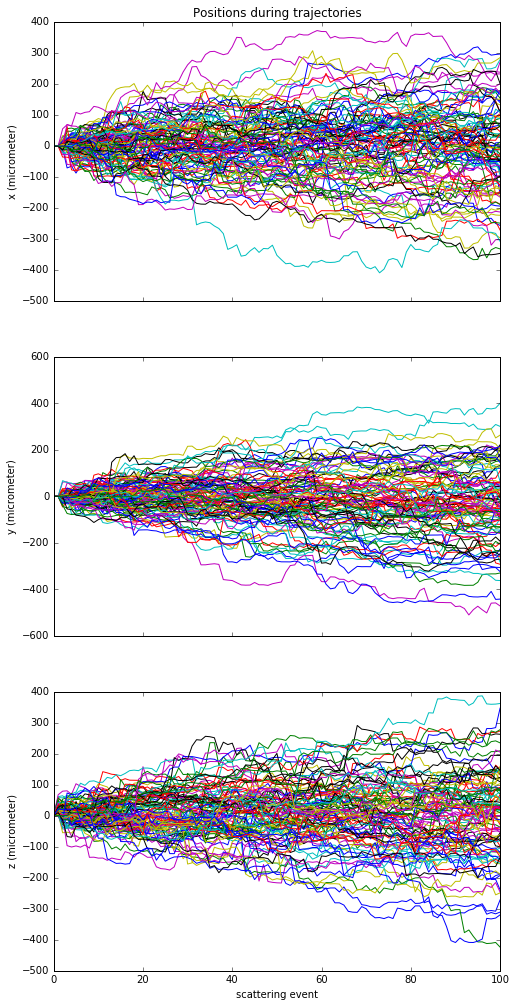

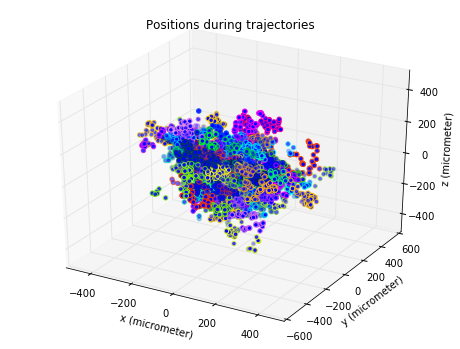

In [5]:
trajectories.plot_coord(ntrajectories, three_dim=True)

## Calculate the fraction of trajectories that are reflected and transmitted

In [6]:
z_low = sc.Quantity('0.0 um')
cutoff = sc.Quantity('50 um')

reflectance, transmittance = mc.calc_refl_trans(trajectories, z_low, cutoff, n_medium, n_sample)

print('R = '+ str(reflectance))
print('T = '+ str(transmittance))
print('Absorption coefficient = ' + str(mu_abs))

R = 0.701378758963
T = 0.298621241037
Absorption coefficient = 1.1116844352234298e-16 1 / micrometer


## Add absorption to the system (in the particle and/or in the matrix)
Having absorption the particle or in the matrix implies that their refractive indices are complex (have a non-zero imaginary component). To include the effect of this absorption into the calculations, we just need to specify the complex refractive index in n_particle and/or n_matrix. Everything else remains the same as for the non-absorbing case.

In [7]:
# Properties of system
n_particle = sc.Quantity(1.54+0.001j, '')     
n_matrix = ri.n('vacuum', wavelen)+0.0001j      
n_sample = ri.n_eff(n_particle, n_matrix, volume_fraction) 

# Calculate the phase function and scattering and absorption coefficients from the single scattering model
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, volume_fraction, wavelen)

# Initialize the trajectories
r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, seed=seed, incidence_angle = 0.)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)
    
# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories.absorb(mu_abs, step)                  
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

# Calculate the fraction of reflected and transmitted trajectories
z_low = sc.Quantity('0.0 um')
cutoff = sc.Quantity('50 um')

reflectance, transmittance = mc.calc_refl_trans(trajectories, z_low, cutoff, n_medium, n_sample)

print('R = '+ str(reflectance))
print('T = '+ str(transmittance))

R = 0.332375217738
T = 0.0482447447981


As expected, the reflected fraction decreases if the system is absorbing. 

## Calculate the reflectance for a system of core-shell particles

When the system is made of core-shell particles, we must specify the refractive index, radius, and volume fraction  of each layer, from innermost to outermost. 

The reflectance is normalized, so it goes from 0 to 1. 

In [8]:
# Properties of system
ntrajectories = 100                     # number of trajectories
nevents = 100                           # number of scattering events in each trajectory
wavelen = sc.Quantity('600 nm')
radius = sc.Quantity(np.array([0.125, 0.13]), 'um')  # specify the radii from innermost to outermost layer
n_particle = sc.Quantity(np.array([1.54,1.33]), '')  # specify the index from innermost to outermost layer           
n_matrix = ri.n('vacuum', wavelen)      
n_medium = ri.n('vacuum', wavelen)     
volume_fraction = sc.Quantity(0.5, '')  # this is the volume fraction of the core-shell particle as a whole

# Calculate the volume fractions of each layer
vf_array = np.empty(len(radius))
r_array = np.array([0] + radius.magnitude.tolist()) 
for r in np.arange(len(r_array)-1):
    vf_array[r] = (r_array[r+1]**3-r_array[r]**3) / (r_array[-1:]**3) * volume_fraction.magnitude

n_sample = ri.n_eff(n_particle, n_matrix, vf_array) 

In [9]:
#%%timeit
# Calculate the phase function and scattering and absorption coefficients from the single scattering model
# (this absorption coefficient is of the scatterer, not of an absorber added to the system)
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, volume_fraction, wavelen)

# Initialize the trajectories
r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, seed=seed, incidence_angle = 0.)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)
    
# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories.absorb(mu_abs, step)                         
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

# Calculate the reflection and transmission fractions
z_low = sc.Quantity('0.0 um')
cutoff = sc.Quantity('50 um')

reflectance, transmittance = mc.calc_refl_trans(trajectories, z_low, cutoff, n_medium, n_sample)

print('R = '+ str(reflectance))
print('T = '+ str(transmittance))

R = 0.769986057833
T = 0.230013942167


## Calculate the reflectance for a polydisperse system 

We can calculate the reflectance of a polydisperse system with either one or two species of particles, meaning that there are one or two mean radii, and each species has its own size distribution. We then need to specify the mean radius, the polydispersity index (pdi), and the concentration of each species. For example, consider a bispecies system of 90$\%$ of 200 nm polystyrene particles and 10$\%$ of 300 nm particles, with each species having a polydispersity index of 1$\%$. In this case, the mean radii are [200, 300] nm, the pdi are [0.01, 0.01], and the concentrations are [0.9, 0.1]. 

If the system is monospecies, we still need to specify the polydispersity parameters in 2-element arrays. For example, the mean radii become [200, 200] nm, the pdi become [0.01, 0.01], and the concentrations become [1.0, 0.0].

To run the code for polydisperse systems, we just need to specify the parameters accounting for polydispersity when calling 'mc.calc_scat()'. 

To include absorption into the polydisperse system calculation, we just need to use the complex refractive index of the particle and/or the matrix. 

The reflectance is normalized, so it goes from 0 to 1. 

Note: the code currently does not handle polydispersity for systems of core-shell particles. 

In [10]:
# Properties of system
n_particle = sc.Quantity(1.54, '')     
n_matrix = ri.n('vacuum', wavelen)   
n_sample = ri.n_eff(n_particle, n_matrix, volume_fraction) 

# define the parameters for polydispersity
radius = sc.Quantity('125 nm')
radius2 = sc.Quantity('150 nm')
concentration = sc.Quantity(np.array([0.9,0.1]), '')
pdi = sc.Quantity(np.array([0.01, 0.01]), '')

# Calculate the phase function and scattering and absorption coefficients from the single scattering model
# Need to specify extra parameters for the polydisperse (and bispecies) case
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, volume_fraction, wavelen, 
                                  radius2=radius2, concentration=concentration, pdi=pdi, polydisperse=True)

# Initialize the trajectories
r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, seed=seed, incidence_angle = 0.)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)
    
# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories.absorb(mu_abs, step)                  
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

# Calculate the reflection and transmission fractions
z_low = sc.Quantity('0.0 um')
cutoff = sc.Quantity('50 um')

reflectance, transmittance = mc.calc_refl_trans(trajectories, z_low, cutoff, n_medium, n_sample)

print('R = '+ str(reflectance))
print('T = '+ str(transmittance))

R = 0.698520701506
T = 0.301479298494


## Calculate the reflectance for a sample with surface roughness

Two classes of surface roughnesses are implemented in the model:

1) When the surface roughness is high compared to the wavelength of light, we assume that light “sees” a nanoparticle before “seeing” the sample as an effective medium. The photons take a step based on the scattering length determined by the nanoparticle Mie resonances, without including the structure factor. After this first step, the photons are inside the sample and proceed to get scattered by the sample as an effective medium. We call this type of roughness "fine", and we input a fine_roughness parameter that is the fraction of the surface covered by "fine" roughness. For example, a fine_roughness of 0.3 means that 30% of incident light will hit fine surface roughness (e.g. will "see" a Mie scatterer first). The rest of the light will see a smooth surface, which could be flat or have coarse roughness. The fine_roughness parameter must be between 0 and 1. 

2) When the surface roughness is low relative to the wavelength, we can assume that light encounters a locally smooth surface with a slope relative to the z=0 plane. The model corrects the Fresnel reflection and refraction to account for the different angles of incidence due to the roughness. The coarse_roughness parameter is the rms slope of the surface and should be larger than 0. There is no upper bound, but when the coarse roughness tends to infinity, the surface becomes too "spiky" and light can no longer hit it, which reduces the reflectance down to 0. 

To run the code with either type of surface roughness, the following functions are called differently:

- calc_scat(): to include fine roughness, need to input fine_roughness > 0. In this case, it returns a 2-element mu_scat, with the first element being the scattering coefficient of the sample as a whole, and the second being the scattering coefficient from Mie theory. If fine_roughness=0, the function returns only the first scattering coefficient in a calculation without roughness.

- initialize(): to include coarse roughness, need to input coarse_roughness > 0, in which case the function returns kz0_rot and kz0_refl that are needed for calc_refl_trans(). 

- sample_step(): to include fine roughness, need to input fine_roughness > 0.

- calc_refl_trans(): to include coarse roughness, need to input kz0_rot and kz0_refl from initialize(). To include fine roughness, need to input fine_roughness and n_matrix.

$\textbf{Note 1:}$ to reiterate, fine_roughness + coarse_roughness can add up to more than 1. Coarse roughness is how much coarse roughness there is on the surface, and it can be larger than 1. The larger the value, the larger the slopes on the surface. Fine roughness is what fraction of the surface is covered by fine surface roughness so it must be between 0 and 1. Both types of roughnesses can be included together or separately into the calculation. 

$\textbf{Note 2:}$ Surface roughness has not yet been implemented to work with spherical boundary conditions. 

In [16]:
# Properties of system
ntrajectories = 100                     # number of trajectories
nevents = 100                           # number of scattering events in each trajectory
wavelen = sc.Quantity('600 nm') 
radius = sc.Quantity('0.125 um')
volume_fraction = sc.Quantity(0.5, '')
n_particle = sc.Quantity(1.54, '')      # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelen)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelen)      # space within sample. n_medium is outside the sample. 
                                        # n_particle and n_matrix can have complex indices if absorption is desired
n_sample = ri.n_eff(n_particle, n_matrix, volume_fraction) 

# Need to specify fine_roughness and coarse_roughness 
fine_roughness = sc.Quantity(0.6, '')
coarse_roughness = sc.Quantity(1.1, '')

# Need to specify fine roughness parameter in this function
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, volume_fraction, wavelen, 
                                  fine_roughness=fine_roughness)

# The output of mc.initialize() depends on whether there is coarse roughness or not
if coarse_roughness > 0.:
    r0, k0, W0, kz0_rotated, kz0_reflected = mc.initialize(nevents, ntrajectories, n_medium, n_sample, seed=seed, 
                                                           incidence_angle=0., coarse_roughness=coarse_roughness)
else: 
    r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, seed=seed, incidence_angle=0., 
                               coarse_roughness=coarse_roughness)
    kz0_rotated = None
    kz0_reflected = None
                
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

# Need to specify the fine roughness parameter in this function
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat, fine_roughness=fine_roughness)
    
trajectories = mc.Trajectory(r0, k0, W0)
trajectories.absorb(mu_abs, step)                  
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

z_low = sc.Quantity('0.0 um')
cutoff = sc.Quantity('50 um')

# If there is coarse roughness, need to specify kz0_rotated and kz0_reflected. If there is fine roughness, 
# need to specify n_matrix in addition to the fine roughness parameter
reflectance, transmittance = mc.calc_refl_trans(trajectories, z_low, cutoff, n_medium, n_sample, kz0_rot=kz0_rotated, 
                                                kz0_refl=kz0_reflected, fine_roughness=fine_roughness, 
                                                n_matrix=n_matrix)
print('R = '+ str(reflectance))
print('T = '+ str(transmittance))

R = 0.754430679993
T = 0.229440571349


## Run photon packets in a medium with a spherical boundary

This is an example code to run a Monte Carlo calculation for photon packets travelling in material with a spherical boundary

##### Set system parameters and initialize the trajectories for a sphere

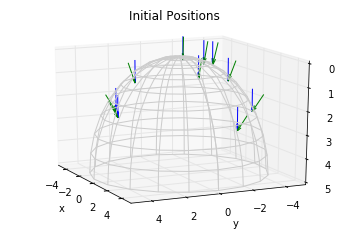

In [12]:
# Properties of system
ntrajectories = 10                     # number of trajectories
nevents = 10                           # number of scattering events in each trajectory
wavelen = sc.Quantity('600 nm')
radius = sc.Quantity('0.125 um')
assembly_radius = sc.Quantity('5 um')
volume_fraction = sc.Quantity(0.5, '')
n_particle = sc.Quantity(1.54, '')      # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelen)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelen)      # space within sample. n_medium is outside the sample.
n_sample = ri.n_eff(n_particle, n_matrix, volume_fraction)

#%%timeit
# Calculate the phase function and scattering and absorption coefficients from the single scattering model
# (this absorption coefficient is of the scatterer, not of an absorber added to the system)
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, volume_fraction, wavelen)

# Initialize the trajectories for a sphere
# set plot_initial to True to see the initial positions of trajectories. The default value of plot_initial is False
r0, k0, W0 = mc.initialize_sphere(nevents, ntrajectories, n_medium, n_sample, 
                                  assembly_radius, plot_initial = True, seed=seed)


##### Set up trajectories object and run the photons
this part is exactly the same as in the film case

In [13]:
# make positions, directions, and weights into quantities with units
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)
    
# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories.absorb(mu_abs, step)                         
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

##### Calculate reflectance and transmittance excluding fresnel reflected trajectories

R = 0.472419255053
T = 0.527580744947


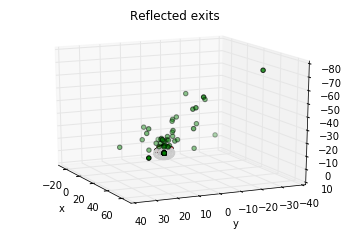

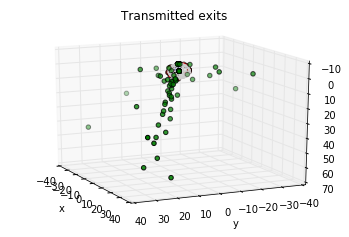

In [17]:
# Calculate reflectance and transmittance
# Set plot_exits to true to plot positions of trajectories just before (red) and after (green) exit.
# The default value of plot_exits is False.
# The default value of run_tir is True, so you must set it to False to exclude the fresnel reflected trajectories. 
reflectance_sphere, transmittance_sphere = mc.calc_refl_trans_sphere(trajectories, n_medium, n_sample, assembly_radius,
                                                                     p, mu_abs, mu_scat, plot_exits = True, 
                                                                     run_tir=False)

print('R = '+ str(reflectance_sphere))
print('T = '+ str(transmittance_sphere))

# ignore runtime warning 
import warnings
warnings.filterwarnings("ignore")

##### Calculate reflectance and transmittance including fresnel reflected trajectories

In [15]:
# Calculate reflectance and transmittance
# The default value of plot_exits is False, so you need not set it to avoid plotting trajectories.
# The default value of run_tir is True, so you need not set it to include fresnel reflected trajectories.
reflectance_sphere_tir, transmittance_sphere_tir = mc.calc_refl_trans_sphere(trajectories, 
                                                                              n_medium, n_sample, 
                                                                              assembly_radius, 
                                                                              p, mu_abs, mu_scat)

print('R = '+ str(reflectance_sphere_tir))
print('T = '+ str(transmittance_sphere_tir))

R = 0.221594077337
T = 0.778405922663
